In [2]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu,SmoothingFunction
import pandas as pd
import numpy as np
import docker
import os
import re
import random
from string import punctuation
import json
import matplotlib.pyplot as plt
punc = punctuation
smooth = SmoothingFunction()

In [280]:
def mythril_get(bb):
    mythril_result = []
    myt = bb['mythril']
    line = bb['contract_line']
    for index,j in enumerate(myt):
        if j != None and len(j) > 0:
            total = []
            for i in j:
                #print(i)
                ccode = i.get('code')
                formatted = {
                    #'address':i['address'],
                    #'code':ccode,
                    'function':i['function'],
                    'lineno':i['lineno'],
                    'title':i['title'],
                    'type':i['type']
                }
                
                if(line[index][0] <= formatted['lineno'] and line[index][1] >= formatted['lineno']):
                    total.append(formatted)
            mythril_result.append(total)
        else:
            mythril_result.append([])
    return mythril_result
def slither_get(bb):
    slither_result = []
    sli = bb['slither']
    line = bb['contract_line']
    for index,j in enumerate(sli):
        if j != None and len(j) > 0:
            temp=[]
            for i in j:
                if len(i['elements']) > 0 and i['elements'][0].get('source_mapping'):
                    func = i['elements'][0].get('name')
                    t = {
                        'title':i['check'],
                        'function':func,
                        #'contract':i['elements'][0].get('contract').get('name'),
                        'lineno':i['elements'][0]['source_mapping']['lines'],
                        'type':i['impact']
                    }
                    #print("t:"+str(t['lineno'][0]))
                    #print('line'+str(line[index][0])+str(line[index][1]))
                    if(len(t['lineno']) > 0 and line[index][0] <= t['lineno'][0] and line[index][1] >= t['lineno'][0]):
                        temp.append(t)
            slither_result.append(temp)
        else:
            slither_result.append([])
    return slither_result
def osiris_get(bb):
    result = []
    osi = bb['osiris']
    line = bb['contract_line']
    count = 0
    for  index,i in enumerate(osi):
        if i != None and len(i) > 0:
            temp = []  
            for j in i:
                error = j['errors']
                name = j['name']
                if len(error) > 0:
                    for ttt in error:
                        t = {
                            'title':ttt['message'],
                            'lineno':ttt['line'],
                            'function':name
                        }
                        if(line[index][0] <= t['lineno'] and line[index][1] >= t['lineno']):
                            temp.append(t)
            result.append(temp)
        else:
            result.append([])
    return result
def owlha(name,bb):
    osi = bb[name]
    count = 0
    for i in osi:
        count = 0
        if i != None and len(i) > 0:
            for j in i:
                print(j)
            #a = i
            #print(i)
            count += 1
            if count == 5:
                break
def find_range(code,f):
    head = code.splitlines()[0]
    hang = f.splitlines()
    for i in range(len(hang)):
        if head in hang[i]:
            a = i
            flag = 1
            j = i+1
            while flag != 0 and j < len(hang):
                if '{' in hang[j]:
                    flag += hang[j].count('{')
                if '}' in hang[j]:
                    flag -= hang[j].count('}')
                j += 1
            return [a,j-1]
    return [0,0]
def find_func_range(code,f):
    head = code.splitlines()[0]
    hang = f.splitlines()
    for i in range(len(hang)):
        if head in hang[i]:
            a = i
            flag = 1
            j = i+1
            while flag != 0 and j < len(hang):
                if '{' in hang[j]:
                    flag += hang[j].count('{')
                if '}' in hang[j]:
                    flag -= hang[j].count('}')
                j += 1
            return [a,j-1]
    print("find_func_range error")
    return [0,0]
def get_contract_line(bb):
    code_range = []
    name = list(bb['code_name'])
    for i in range(len(name)):
        try:
            f = open(''+name[i],encoding = 'utf-8').read()
        except:
            f = open(''+name[i],encoding = 'GBK').read()
        code = bb.loc[i,'contract_code']
        con_range = find_range(code,f)
        code_range.append(con_range)
    return code_range
def get_function_line(bb):
    code_range = []
    name = list(bb['code_name'])
    for i in range(len(name)):
        try:
            f = open(''+name[i],encoding = 'utf-8').read()
        except:
            f = open(''+name[i],encoding = 'GBK').read()
        code = bb.loc[i,'contract_code']
        con_range = find_func_range(code,f)
        code_range.append(con_range)
    return code_range
def add_sol(sol_name,target):
    temp = target[sol_name]
    #print(temp[0])
    for i in range(len(temp)):
        if '.sol' not in temp[i]:
            temp[i] += '.sol'
    target[sol_name] = temp
def check_len(x):
    return len(x)
def print_code(addr):
    ttt = open(""+addr).read().splitlines()
    for index,i in enumerate(ttt):
        print(str(index)+i)
def func_code(coindex):
    ana = bb[bb['code_index'] == coindex].iloc[0]
    #print(ana['contract_code'])
    for j in ['osiris_analysis','mythril_analysis_not_info','slither_analysis_not_info']:
        print(j)
        for i in ana[j]:
            print(i)
        print()
    def spli(x):
        return x.split('-')[0]
    def include_f(x,y):
        return y in eval(x)['href']
    temp2 = bb[bb['code_index'] == coindex]['sni_name'].apply(spli)
    print(list(temp2))
    for i in temp2:
        temp = post[post['info'].apply(include_f,y = i)]
        print(eval(temp.iloc[0]['info'])['href'])
    print_code(ana['code_name'])

In [281]:
runType = 'con'

In [282]:


json_root = ''#contract
if runType == 'fun':
    json_root = 'func'

mythril_name = 'mythril.json'
osiris_name = 'osiris.json'
slither_name = 'slither.json'

conOri = 'conOri'
conRep = 'conRep'
funOri = 'funOri'
funRep = 'funRep'


"\nmythril_name = funRep + 'mythril.json'\nosiris_name = funRep + 'osiris.json'\nslither_name = funRep + 'slither.json'\n"

In [283]:
mythril=pd.read_json(os.path.join(json_root,mythril_name))
slither=pd.read_json(os.path.join(json_root,slither_name))
osiris=pd.read_json(os.path.join(json_root,osiris_name))
#rep
def dropSuffix(src):
    src['withsuffixName'] = src['sol_name']
    src['sol_name'] = src['sol_name'].apply(lambda x : x.split('_')[0] + '.sol')
dropSuffix(mythril)
dropSuffix(slither)
dropSuffix(osiris)

In [296]:
snippet

,sol_name,code
0,7089-1.sol,contract multiowned { struct PendingState { ui...
1,7089-1.sol,contract daylimit is multiowned { modifier lim...
2,7089-1.sol,contract multisig { event Deposit(address from...
3,27167-0.sol,contract MyContract {\n\n bytes32 publ...
4,33837-0.sol,contract Casino {\n\n\n uint minimumBet;\n ...
...,...,...
7156,74722-0-0.sol,contract IWETH is ERC20 {\n event Deposit(add...
7157,25554-0-0.sol,contract SimpleStorage {\n uint storedData;...
7158,57690-1-0.sol,contract TestMethod{\n string public name = ...
7159,55670-0-0.sol,contract TestToken is StandardToken {\n usi...


In [284]:
#function

codePath = '16w_function_v2.csv'
sniPath = 'snippet_function_v2.csv'
matchPath = 'function_match_v2.csv'
if runType == 'con':
    sniPath = 'snippet_contract_v2.csv'
    codePath = '16w_contract_v2.csv'
    matchPath = 'contract_match_true.csv'

#snippet = pd.read_csv(sni_function).drop_duplicates(['dealed_code']).reset_index()
#code = pd.read_csv(code_function).drop_duplicates(['dealed_code']).reset_index()
#match = pd.read_csv(func_match)
#match = pd.read_csv('append_contract_data.csv')
#snippet_func =pd.read_csv('snippet_function_v2.csv').drop_duplicates(['dealed_code'])
#function = pd.read_csv('16w_function_v2.csv').drop_duplicates(['dealed_code'])
#match_func = pd.read_csv('function_match_true.csv')
#match_func = match_func[match_func['bleu'] > 0.9]
#match2 = pd.read_csv('popular_contract.csv')
#match2 = list(match2['snippet'])

In [285]:
snippet = pd.read_csv(sniPath)
code = pd.read_csv(codePath)
match = pd.read_csv(matchPath)
#replace
#match = match[match['0'] != '[]']

In [286]:
#func
if runType == 'fun':
    match = pd.read_csv(matchPath)
    seg0 = pd.read_csv("segment_0.9.csv")
    seg1 = pd.read_csv("segment_0.8.csv")
    func_index = list(seg0[seg0['check'] < 2]['sni_index'].append(seg1[seg1['check'] < 2]['sni_index']).append(match[match['bleu'] == 1]['snippet']).drop_duplicates())
    match = match[match['snippet'].apply((lambda x,a:x in a),a=func_index)]
    match

In [287]:
#con
if runType == 'con':
    snippet['index'] = snippet.index
    match = pd.read_csv(matchPath)
    seg0 = pd.read_csv("segment_0.9.csv")
    seg1 = pd.read_csv("segment_0.8.csv")
    seg2 = pd.read_csv("segment_0.7.csv")
    temp = list(seg0[seg0['check'] < 2]['sni'])
    temp += (list(seg1[seg1['check'] < 2]['sni']))
    temp+= (list(seg2[seg2['check'] < 2]['sni']))
    func_index = snippet[snippet['code'].apply(lambda x : x in temp)]['index']
    temp = match[match['snippet'].apply((lambda x,a:x in a),a=func_index)]
    match = temp.append(match[match['bleu'] == 1])


'\nmatch_append = match[\'snippet\'].apply(lambda x : int(x))\n#并集\nuniontemp = list(set(match_append).union(set(match[\'snippet\'])))\nuniontemp\nlen(uniontemp)\ncontract_bleu = pd.read_csv(\'/home/yfliu/paper_data/contract_bleu.csv\')\ncontract_bleu = contract_bleu[\'Unnamed: 0\']\n\n\nnew_df = pd.read_csv("/data/contract_source_code_with_reuse_times_5_5.csv")\ndel new_df[\'Unnamed: 0\']\nnew_df = new_df.drop_duplicates()\nnew_df\n\n\nseg0 = pd.read_csv("/home/yfliu/manual_inspection/after_function/segment_0.9.csv")\nseg1 = pd.read_csv("/home/yfliu/manual_inspection/after_function/segment_0.8.csv")\nfunc_index = list(seg0[seg0[\'check\'] <= 1][\'sni_index\'].append(seg1[seg1[\'check\'] <= 1][\'sni_index\']).append(match[match[\'bleu\'] == 1][\'snippet\']).drop_duplicates())\nmatch = match[match[\'snippet\'].apply((lambda x,a:x in a),a=func_index)]\nmatch'

In [289]:
#多种结果mapping到十种情况中
head = [' access_control ',
 ' arithmetic ',
 ' denial_service ',
 ' reentrancy ',
 ' unchecked_low_calls ',
 ' bad_randomness ',
 ' front_running ',
 ' time_manipulation ',
 ' short_addresses ',
 ' Other ',
 ' Ignore ']
dic = dict(zip(head,[0]*10))
mapping = open('mapping.json').read()
mapp = json.loads(mapping)
#重要程度

slither_map = mapp['slither']
slither_key = slither_map.keys()
slither_type_map = dict(zip(slither_key,[0]*len(slither_key)))
u = open('temp.txt').read()
for i in u.splitlines():
    sp = i.split()
    slither_type_map[sp[1]] = sp[-2]
slither_type_map
slither_type_map['constant-function'] = 'Medium'
slither_bug_patch = ['constable-states','erc20-indexed','erc20-interface','external-function','incorrect-equality','naming-convention','shadowing-local','shadowing-state','shadowing-builtin','shadowing-abstract']

In [290]:
#获得bb
sni_index = 'snippet'
code_index = 'code'
sni_index = ''
snippet = snippet[['sol_name','code']]
code_name = []
contract_code = []
sni_name = []
sni_code = []
dealed_code = []
for index,i in match.iterrows():
    #print(i)
    #a = snippet.loc[i['snippet']]
    a = snippet.loc[int(i['snippet'])]
    #b = code.loc[i['code']]
    b = code.loc[int((i['code']))]
    #b = code.loc[eval((i['code']))[0]]# replace
    code_name.append(b['code_name'])
    contract_code.append(b['code'])
    dealed_code.append(b['dealed_code'])
    sni_name.append(a['sol_name'])
    sni_code.append(a['code'])
bb = pd.DataFrame({
    'sni_index':list(match['snippet']),
    'code_index':[int(item) for item in list(match['code'])],
    #'code_index':[int(eval(item)[0]) for item in list(match['code'])],
    'code_name':code_name,
    'dealed_code':dealed_code,
    'sni_name':sni_name,
    'contract_code':contract_code,
    'sni_code':sni_code
})
#为结果添加.sol方便下一步处理 确定contract在完整合约的范围 把工具结果(未处理)贴上去
bname = bb['code_name']
bb['contract_line'] = get_contract_line(bb)
slither = slither.reset_index()

In [291]:
#slither = slither.reset_index()
#3个工具和analysis加上去
tools = [mythril,osiris,slither]
toolss = ['mythril','osiris','slither']
#把三个原本工具加上去
for target in range(len(tools)):
    #add_sol('sol_name',tools[target])
    name = tools[target]['sol_name']
    result = tools[target]['result']
    m = {}
    for i in range(len(name)):
        m[name[i]] = result[i]
    temp_a = list(bb['code_name'])#code_name
    add = []
    #try:
    for i in range(len(temp_a)):
        if temp_a[i] in m.keys():
            add.append(m[temp_a[i]])
        else:
            add.append([])
    '''except:
        add.append([])
        print('error')
        #break'''
    bb[toolss[target]] = add
bb['slither_analysis'] = slither_get(bb)
bb['osiris_analysis'] = osiris_get(bb)
bb['mythril_analysis'] = mythril_get(bb)
bb

,sni_index,code_index,code_name,dealed_code,sni_name,contract_code,sni_code,contract_line,mythril,osiris,slither,slither_analysis,osiris_analysis,mythril_analysis
0,8,21772,0x6d056af97b52e343ce646fa79cf09ca735ff8db5.sol,"['contract', 'MomsAvenueToken', 'function', 't...",37927-0.sol,contract MomsAvenueToken {\n function trans...,contract MyToken {\n function transferF...,"[33, 35]",[],"[{'errors': [], 'file': '/../data_sol/0x6d056a...","[{'check': 'external-function', 'impact': 'Inf...","[{'title': 'external-function', 'function': 't...",[],[]
1,29,23020,0x59f243d056ada87eb563c2d507fe4822f8ccccac.sol,"['contract', 'MSD4', 'function', 'greenOnFanCh...",84331-2.sol,contract MSD4 {\n\n \n\n function greenOn...,contract Tested1 {\n function func() public...,"[36, 46]",[],[],[],[],[],[]
2,31,716,0x439f4b2d7b7dfcde4d63efb075ebe250613bebd6.sol,"['contract', 'mortal', 'address', 'owner', 'fu...",7028-0.sol,contract mortal\n{\n address owner;\n\n ...,contract mortal { address owner; function mort...,"[2, 34]",[],"[{'errors': [], 'file': '/../data_sol/0x439f4b...","[{'check': 'external-function', 'impact': 'Inf...","[{'title': 'external-function', 'function': 'k...",[],[]
3,32,2847,0x1a8ee1619397329de9b1161ed59d937744fdcc9d.sol,"['contract', 'Greeter', 'is', 'Mortal', 'strin...",7028-0.sol,contract Greeter is Mortal {\n \n string...,contract greeter is mortal { string greeting; ...,"[11, 24]",None,"[{'errors': [], 'file': '/../data_sol/0x1a8ee1...","[{'check': 'external-function', 'impact': 'Inf...","[{'title': 'external-function', 'function': 'g...",[],[]
4,45,61793,0x9622d66f1772531e04df2c3f83601d9b04d10db2.sol,"['contract', 'Test', 'uint', 'public', 'test',...",15435-1.sol,contract Test {\n uint public test;\n \n...,contract Test { uint256 public value; function...,"[2, 8]",[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,6787,46387,0xf8c35f1cf2dc4dbeaeeb2ecb298a80b506a5781d.sol,"['contract', 'DAOCreator', 'function', 'create...",9000-1-0.sol,contract DAO_Creator {\n function createDAO...,contract DAO_Creator {\n function createDAO...,"[1112, 1129]",None,[],[],[],[],[]
793,6810,311,0x9f623e51165102c1b7febbbbc25b76c751633155.sol,"['contract', 'ApproveAndCallFallBack', 'functi...",70273-1-1.sol,contract ApproveAndCallFallBack {\n functio...,contract ApproveAndCallFallBack {\n functio...,"[64, 66]",[],[],[],[],[],[]
794,6876,26019,0xeed72e272a76a0641951a6b3caba017336359014.sol,"['contract', 'Verifier', 'function', 'verifySt...",69058-0-3.sol,contract Verifier {\n\n \n\n function verify...,contract Verifier {\n \n function verifyStri...,"[10, 130]","[{'address': 104, 'code': 'yString(string mess...","[{'errors': [], 'file': '/../data_sol/0xeed72e...","[{'check': 'constant-function', 'impact': 'Med...","[{'title': 'assembly', 'function': 'verifyStri...",[],"[{'function': 'verifyString(string,uint8,bytes..."
795,6938,7324,0x6ba2fa9f8ad7b7c376210c0fb4fd311a66d98e8e.sol,"['contract', 'Bakery', 'address', 'public', 'c...",13415-0-0.sol,contract Bakery {\n\n\n\n \n\n\n\n address[]...,contract Bakery {\n\n \n\n address[] public ...,"[12, 64]",[],[],"[{'check': 'locked-ether', 'impact': 'Medium',...","[{'title': 'external-function', 'function': 'g...",[],[]


In [292]:
slither_temp = list(bb['slither_analysis'])
slither_info = []
for item in slither_temp:
    del_list = []
    info_list = []
    for index,t_item in enumerate(item):
        title = t_item['title']
        level = slither_type_map[title]
        if level == 'Informational' or title in slither_bug_patch:
            del_list.append(index)
    del_list.reverse()
    for tempt in del_list:
        info_list.append(item[tempt])
        del item[tempt]
    slither_info.append(info_list)
bb['slither_analysis_not_info'] = slither_temp
#bb['slither_analysis_info'] = slither_info
slither_temp = list(bb['mythril_analysis'])
slither_info = []
for item in slither_temp:
    del_list = []
    info_list = []
    for index,t_item in enumerate(item):
        #title = t_item['title']
        level = t_item['type']
        if level != 'Warning':
            del_list.append(index)
    del_list.reverse()
    for tempt in del_list:
        info_list.append(item[tempt])
        del item[tempt]
    slither_info.append(info_list)
bb['mythril_analysis_not_info'] = slither_temp
#bb['mythril_analysis_info'] = slither_info

del bb['mythril_analysis']
del bb['slither_analysis']
bb#对slither mythril做了处理，去除掉其中不重要的部分

,sni_index,code_index,code_name,dealed_code,sni_name,contract_code,sni_code,contract_line,mythril,osiris,slither,osiris_analysis,slither_analysis_not_info,mythril_analysis_not_info
0,8,21772,0x6d056af97b52e343ce646fa79cf09ca735ff8db5.sol,"['contract', 'MomsAvenueToken', 'function', 't...",37927-0.sol,contract MomsAvenueToken {\n function trans...,contract MyToken {\n function transferF...,"[33, 35]",[],"[{'errors': [], 'file': '/../data_sol/0x6d056a...","[{'check': 'external-function', 'impact': 'Inf...",[],[],[]
1,29,23020,0x59f243d056ada87eb563c2d507fe4822f8ccccac.sol,"['contract', 'MSD4', 'function', 'greenOnFanCh...",84331-2.sol,contract MSD4 {\n\n \n\n function greenOn...,contract Tested1 {\n function func() public...,"[36, 46]",[],[],[],[],[],[]
2,31,716,0x439f4b2d7b7dfcde4d63efb075ebe250613bebd6.sol,"['contract', 'mortal', 'address', 'owner', 'fu...",7028-0.sol,contract mortal\n{\n address owner;\n\n ...,contract mortal { address owner; function mort...,"[2, 34]",[],"[{'errors': [], 'file': '/../data_sol/0x439f4b...","[{'check': 'external-function', 'impact': 'Inf...",[],[],[]
3,32,2847,0x1a8ee1619397329de9b1161ed59d937744fdcc9d.sol,"['contract', 'Greeter', 'is', 'Mortal', 'strin...",7028-0.sol,contract Greeter is Mortal {\n \n string...,contract greeter is mortal { string greeting; ...,"[11, 24]",None,"[{'errors': [], 'file': '/../data_sol/0x1a8ee1...","[{'check': 'external-function', 'impact': 'Inf...",[],[],[]
4,45,61793,0x9622d66f1772531e04df2c3f83601d9b04d10db2.sol,"['contract', 'Test', 'uint', 'public', 'test',...",15435-1.sol,contract Test {\n uint public test;\n \n...,contract Test { uint256 public value; function...,"[2, 8]",[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,6787,46387,0xf8c35f1cf2dc4dbeaeeb2ecb298a80b506a5781d.sol,"['contract', 'DAOCreator', 'function', 'create...",9000-1-0.sol,contract DAO_Creator {\n function createDAO...,contract DAO_Creator {\n function createDAO...,"[1112, 1129]",None,[],[],[],[],[]
793,6810,311,0x9f623e51165102c1b7febbbbc25b76c751633155.sol,"['contract', 'ApproveAndCallFallBack', 'functi...",70273-1-1.sol,contract ApproveAndCallFallBack {\n functio...,contract ApproveAndCallFallBack {\n functio...,"[64, 66]",[],[],[],[],[],[]
794,6876,26019,0xeed72e272a76a0641951a6b3caba017336359014.sol,"['contract', 'Verifier', 'function', 'verifySt...",69058-0-3.sol,contract Verifier {\n\n \n\n function verify...,contract Verifier {\n \n function verifyStri...,"[10, 130]","[{'address': 104, 'code': 'yString(string mess...","[{'errors': [], 'file': '/../data_sol/0xeed72e...","[{'check': 'constant-function', 'impact': 'Med...",[],[],"[{'function': 'verifyString(string,uint8,bytes..."
795,6938,7324,0x6ba2fa9f8ad7b7c376210c0fb4fd311a66d98e8e.sol,"['contract', 'Bakery', 'address', 'public', 'c...",13415-0-0.sol,contract Bakery {\n\n\n\n \n\n\n\n address[]...,contract Bakery {\n\n \n\n address[] public ...,"[12, 64]",[],[],"[{'check': 'locked-ether', 'impact': 'Medium',...",[],[],[]


In [293]:
cc =bb.copy()

cc = cc.reset_index()
cc#根据code_index再次去重，这样获得的是完整合约

,index,sni_index,code_index,code_name,dealed_code,sni_name,contract_code,sni_code,contract_line,mythril,osiris,slither,osiris_analysis,slither_analysis_not_info,mythril_analysis_not_info
0,0,8,21772,0x6d056af97b52e343ce646fa79cf09ca735ff8db5.sol,"['contract', 'MomsAvenueToken', 'function', 't...",37927-0.sol,contract MomsAvenueToken {\n function trans...,contract MyToken {\n function transferF...,"[33, 35]",[],"[{'errors': [], 'file': '/../data_sol/0x6d056a...","[{'check': 'external-function', 'impact': 'Inf...",[],[],[]
1,1,29,23020,0x59f243d056ada87eb563c2d507fe4822f8ccccac.sol,"['contract', 'MSD4', 'function', 'greenOnFanCh...",84331-2.sol,contract MSD4 {\n\n \n\n function greenOn...,contract Tested1 {\n function func() public...,"[36, 46]",[],[],[],[],[],[]
2,2,31,716,0x439f4b2d7b7dfcde4d63efb075ebe250613bebd6.sol,"['contract', 'mortal', 'address', 'owner', 'fu...",7028-0.sol,contract mortal\n{\n address owner;\n\n ...,contract mortal { address owner; function mort...,"[2, 34]",[],"[{'errors': [], 'file': '/../data_sol/0x439f4b...","[{'check': 'external-function', 'impact': 'Inf...",[],[],[]
3,3,32,2847,0x1a8ee1619397329de9b1161ed59d937744fdcc9d.sol,"['contract', 'Greeter', 'is', 'Mortal', 'strin...",7028-0.sol,contract Greeter is Mortal {\n \n string...,contract greeter is mortal { string greeting; ...,"[11, 24]",None,"[{'errors': [], 'file': '/../data_sol/0x1a8ee1...","[{'check': 'external-function', 'impact': 'Inf...",[],[],[]
4,4,45,61793,0x9622d66f1772531e04df2c3f83601d9b04d10db2.sol,"['contract', 'Test', 'uint', 'public', 'test',...",15435-1.sol,contract Test {\n uint public test;\n \n...,contract Test { uint256 public value; function...,"[2, 8]",[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,792,6787,46387,0xf8c35f1cf2dc4dbeaeeb2ecb298a80b506a5781d.sol,"['contract', 'DAOCreator', 'function', 'create...",9000-1-0.sol,contract DAO_Creator {\n function createDAO...,contract DAO_Creator {\n function createDAO...,"[1112, 1129]",None,[],[],[],[],[]
793,793,6810,311,0x9f623e51165102c1b7febbbbc25b76c751633155.sol,"['contract', 'ApproveAndCallFallBack', 'functi...",70273-1-1.sol,contract ApproveAndCallFallBack {\n functio...,contract ApproveAndCallFallBack {\n functio...,"[64, 66]",[],[],[],[],[],[]
794,794,6876,26019,0xeed72e272a76a0641951a6b3caba017336359014.sol,"['contract', 'Verifier', 'function', 'verifySt...",69058-0-3.sol,contract Verifier {\n\n \n\n function verify...,contract Verifier {\n \n function verifyStri...,"[10, 130]","[{'address': 104, 'code': 'yString(string mess...","[{'errors': [], 'file': '/../data_sol/0xeed72e...","[{'check': 'constant-function', 'impact': 'Med...",[],[],"[{'function': 'verifyString(string,uint8,bytes..."
795,795,6938,7324,0x6ba2fa9f8ad7b7c376210c0fb4fd311a66d98e8e.sol,"['contract', 'Bakery', 'address', 'public', 'c...",13415-0-0.sol,contract Bakery {\n\n\n\n \n\n\n\n address[]...,contract Bakery {\n\n \n\n address[] public ...,"[12, 64]",[],[],"[{'check': 'locked-ether', 'impact': 'Medium',...",[],[],[]


In [294]:
if runType == 'con':
    cc.to_csv('contractRes.csv',index = False)
else:
    cc.to_csv('functionRes.csv',index = False)

In [297]:
snippet

,sol_name,code
0,7089-1.sol,contract multiowned { struct PendingState { ui...
1,7089-1.sol,contract daylimit is multiowned { modifier lim...
2,7089-1.sol,contract multisig { event Deposit(address from...
3,27167-0.sol,contract MyContract {\n\n bytes32 publ...
4,33837-0.sol,contract Casino {\n\n\n uint minimumBet;\n ...
...,...,...
7156,74722-0-0.sol,contract IWETH is ERC20 {\n event Deposit(add...
7157,25554-0-0.sol,contract SimpleStorage {\n uint storedData;...
7158,57690-1-0.sol,contract TestMethod{\n string public name = ...
7159,55670-0-0.sol,contract TestToken is StandardToken {\n usi...


In [295]:
name3 = ['mythril_analysis_not_info','osiris_analysis','slither_analysis_not_info']
mapRes = {}
for name2 in name3:
    #显示结果
    name_ = name2.split('_')[0]
    print(name_)
    myy = list(cc[name2])
    settemp = {}
    for index,row in cc.iterrows():
        i = row[name2]
        if len(i)>0:
            for j in i:
                if j['title'] in settemp.keys():
                    settemp[j['title']] += 1
                    #settemp[j['title']] += row['reuse']
                else:
                    #settemp[j['title']] = row['reuse']
                    settemp[j['title']] = 1
    for i in settemp:
        print(mapp[name_][i.strip()],end=' ')
        print(settemp[i])
        if mapp[name_][i.strip()] in mapRes.keys():
            mapRes[mapp[name_][i.strip()]] += settemp[i]
        else:
            mapRes[mapp[name_][i.strip()]] = settemp[i]
        
    #print(settemp)
    count=0
    for i in settemp.values():
        count+=i
    keys1 = settemp.keys()
print(mapRes)

mythril
 arithmetic  136
 arithmetic  22
 reentrancy  15
 access_control  4
 reentrancy  9
 front_running  17
 Other  21
 access_control  3
osiris
 arithmetic  123
 arithmetic  57
 Ignore  43
 time_manipulation  14
 denial_service  2
 arithmetic  9
 reentrancy  1
slither
 reentrancy  6
 access_control  9
 Other  8
 time_manipulation  8
 unchecked_low_calls  20
 reentrancy  15
 denial_service  21
 Other  1
 reentrancy  17
 Other  1
 access_control  4
 Other  7
 access_control  1
{' arithmetic ': 347, ' reentrancy ': 63, ' access_control ': 21, ' front_running ': 17, ' Other ': 38, ' Ignore ': 43, ' time_manipulation ': 22, ' denial_service ': 23, ' unchecked_low_calls ': 20}


In [74]:
def len_f(x):
    return len(x)
dd = cc[cc['mythril_analysis_not_info'].apply(len_f) + cc['slither_analysis_not_info'].apply(len_f) + cc['osiris_analysis'].apply(len_f) > 0]
dd.reset_index()

,level_0,index,code_index,code_name,dealed_code,contract_code,contract_line,osiris_analysis,slither_analysis_not_info,mythril_analysis_not_info,reuse
0,12,12,453,0x81691db780635475700bd666402343b3c9e8d1bc.sol,"['contract', 'GChain', 'is', 'EIP20Interface',...",contract GChain is EIP20Interface {\n\n uin...,"[49, 105]","[{'title': 'overflow_bugs', 'lineno': 76, 'fun...",[],"[{'function': 'transferFrom(address,address,ui...",220
1,13,13,40664,0xbe16ba60960a5e92bc878814dddc736252db8f32.sol,"['contract', 'DappTutorial', 'uint', 'storedDa...",contract DappTutorial {\n uint storedData;\n\...,"[2, 12]","[{'title': 'overflow_bugs', 'lineno': 11, 'fun...",[],[],30
2,17,17,66,0x6ce34eb6866e7c68b293402b01784b271d4f5dea.sol,"['contract', 'StandardToken', 'is', 'Token', '...",contract StandardToken is Token {\n\n\n\n f...,"[62, 142]","[{'title': 'overflow_bugs', 'lineno': 93, 'fun...",[],[],9332
3,32,32,1603,0x654448d920e7bec27807407dbc88335fa1309460.sol,"['contract', 'Intex', 'is', 'StandardToken', '...",contract Intex is StandardToken { \n\n\n\n ...,"[180, 290]","[{'title': 'overflow_bugs', 'lineno': 245, 'fu...",[],[],800
4,38,38,935,0xf9F7c29CFdf19FCf1f2AA6B84aA367Bcf1bD1676.sol,"['contract', 'BurnableToken', 'is', 'StandardT...",contract BurnableToken is StandardToken {\n\n ...,"[506, 525]",[],[],"[{'function': 'tokenFallback(address,uint256,b...",0
...,...,...,...,...,...,...,...,...,...,...,...
147,590,590,1251,0xe78e6e9f60006c858fad070467827b21ed371b9d.sol,"['contract', 'token', 'function', 'transferadd...",contract token { function transfer(address rec...,"[82, 134]",[],"[{'title': 'calls-loop', 'function': 'distribu...",[],1288
148,591,591,55361,0x49592d97be49033615a7fbc02c6853e4c58eb9bc.sol,"['contract', 'TokenERC20', 'string', 'public',...",contract TokenERC20 {\n\n \n\n string pu...,"[8, 298]","[{'title': 'overflow_bugs', 'lineno': 47, 'fun...",[],"[{'function': 'transfer(address,uint256)', 'li...",3
149,604,604,1151,0x2a99257024056ac4268d54329ba10b9cbc313d47.sol,"['contract', 'Ownable']",contract Ownable {},"[12, 566]",[],"[{'title': 'locked-ether', 'function': 'fallba...","[{'function': 'makePayout()', 'lineno': 151, '...",1
150,612,612,26019,0xeed72e272a76a0641951a6b3caba017336359014.sol,"['contract', 'Verifier', 'function', 'verifySt...",contract Verifier {\n\n \n\n function verify...,"[10, 130]",[],[],"[{'function': 'verifyString(string,uint8,bytes...",1


In [27]:
temp_dd = dd['contract_code']
temp_dd = pd.DataFrame({
    'contract':temp_dd
})
temp_dd

,contract
12,contract GChain is EIP20Interface {\n\n uin...
13,contract DappTutorial {\n uint storedData;\n\...
17,contract StandardToken is Token {\n\n\n\n f...
32,contract Intex is StandardToken { \n\n\n\n ...
38,contract BurnableToken is StandardToken {\n\n ...
...,...
590,contract token { function transfer(address rec...
591,contract TokenERC20 {\n\n \n\n string pu...
604,contract Ownable {}
612,contract Verifier {\n\n \n\n function verify...


In [57]:
#指定某一bug生成

def get_error_by_tool(tool,error_name,bb,flag2):
    deal_code = []
    bb_tool = bb[bb[tool].apply(check_len) > 0]
    count = 0
    for i in range(len(bb_tool)):
        flag = False
        row = bb_tool.iloc[i]
        tttt = 0
        for j in row[tool]:
            if j['title'] == error_name:
                    #print(j)
                    tttt+=1
                    flag = True
        if flag == True and flag2:
            tempc = row['dealed_code']
            f3 =True
            for tt in deal_code:
                t = sentence_bleu([tt],tempc,smoothing_function=smooth.method1)
                if(t >= 0.95):
                    f3 = False
                    break
            if(f3 == True):
                for j in row[tool]:
                    if j['title'] == error_name:
                            print(j)
                print("index:"+str(row['code_index']))
                deal_code.append(row['dealed_code']) 
                count+=tttt
                #count+=1
                print('------------------------------'+str(count))
                print(row['code_name'])
                print_code(row['code_name'])
                print('--------------------------------------------------------------------') 
    #print(error_name + ' '+str(count))
#for ii in list(keys1):#    get_error_by_tool(name2,ii,cc,True)
get_error_by_tool('mythril_analysis_not_info','State change after external call',cc,True)


{'function': 'withdraw()', 'lineno': 19, 'title': 'State change after external call', 'type': 'Warning'}
index:53109
------------------------------1
0xb7c5c5aa4d42967efe906e1b66cb8df9cebf04f7.sol
0pragma solidity ^0.4.23;
1
2/*
3!!! THIS CONTRACT IS EXPLOITABLE AND FOR EDUCATIONAL PURPOSES ONLY !!!
4
5This smart contract allows a user to (insecurely) store funds
6in this smart contract and withdraw them at any later point in time
7*/
8
9contract keepMyEther {
10    mapping(address => uint256) public balances;
11    
12    function () payable public {
13        balances[msg.sender] += msg.value;
14    }
15    
16    function withdraw() public {
17        msg.sender.call.value(balances[msg.sender])();
18        balances[msg.sender] = 0;
19    }
20}
--------------------------------------------------------------------
{'function': 'buyTokens(uint256)', 'lineno': 93, 'title': 'State change after external call', 'type': 'Warning'}
index:6929
------------------------------2
0xf796eb0a13b5a75e

In [79]:
post = pd.read_csv('post_with_code.csv')
indexcode = list(dd['code_index'])
count = -1
indexcode[count]

2597

In [80]:
count += 1
print(indexcode[count])
print(count)
func_code(int(indexcode[count]))

47074
0
osiris_analysis
{'title': 'overflow_bugs', 'lineno': 21, 'function': 'ArbitrageCoin'}

mythril_analysis_not_info
{'function': 'mint(address,uint256)', 'lineno': 21, 'title': 'Integer Overflow ', 'type': 'Warning'}

slither_analysis_not_info

['61389']
/questions/61389/ethers-js-node-js-call-solidity-function-that-is-payable
0pragma solidity ^0.4.0;
1
2contract ArbitrageCoin {
3    // The keyword "public" makes those variables
4    // readable from outside.
5    address public minter;
6    mapping (address => uint) public balances;
7
8    // Events allow light clients to react on
9    // changes efficiently.
10    event Sent(address from, address to, uint amount);
11
12    // This is the constructor whose code is
13    // run only when the contract is created.
14    function Coin() public {
15        minter = msg.sender;
16    }
17
18    function mint(address receiver, uint amount) public {
19        if (msg.sender != minter) return;
20        balances[receiver] += amount;
21   

In [ ]:
#随机生成

In [ ]:
aa = bb
bb = cc

In [ ]:
#流行度在75%以上，并且有bug的表
def my_func(x):
    if x in match2:
        return True
    return False
bug_full = bug_ana[bug_ana['sni_index'].apply(my_func) == True]
#bug_full.to_csv('bug_full.csv',index = False)

In [ ]:

mythr = {' access_control ': 10, ' arithmetic ': 167, ' denial_service ': 0, ' reentrancy ': 58, ' unchecked_low_calls ': 2, ' bad_randomness ': 0, ' front_running ': 17, ' time_manipulation ': 0, ' short_addresses ': 0, ' Other ': 77}
barr(mythr.keys(),mythr.values())
sli ={' access_control ': 14, ' arithmetic ': 0, ' denial_service ': 19, ' reentrancy ': 38, ' unchecked_low_calls ': 41, ' bad_randomness ': 0, ' front_running ': 0, ' time_manipulation ': 8, ' short_addresses ': 0, ' Other ': 24}
barr(sli.keys(),sli.values())
osi ={' access_control ': 0, ' arithmetic ': 215, ' denial_service ': 2, ' reentrancy ': 1, ' unchecked_low_calls ': 0, ' bad_randomness ': 0, ' front_running ': 0, ' time_manipulation ': 18, ' short_addresses ': 0, ' Other ': 0}
barr(osi.keys(),osi.values())

In [10]:
# new_df
new_df = pd.read_csv("contract_source_code_with_reuse_times_5_5.csv")
del new_df['Unnamed: 0']
new_df = new_df.drop_duplicates()
cc['reuse'] = len(cc) * [0]
bb_addr = list(bb['code_name'])
for index,row in new_df.iterrows():
    if(row['address'] in bb_addr):
        temp_row = cc[cc['code_name'] == row['address']]
        for index2,row2 in temp_row.iterrows():
            temp_row2 = eval(row2['dealed_code'])[1]
            if row['name'] in temp_row2:
                cc.loc[cc['index'] == row2['index'],'reuse'] = row['reusetime']
cc

NameError: name 'cc' is not defined

In [47]:
temp_use = new_df['reusetime']
temp_use.sort_values()
temp_use.describe()

count      633.000000
mean      1364.603476
std       5131.661245
min          1.000000
25%          3.000000
50%         53.000000
75%        800.000000
max      48108.000000
Name: reusetime, dtype: float64

In [46]:
new_df.loc[295]

address      0x441398b701809c617004a93eba2c9c701d439375.sol
name                                           ForeignToken
reusetime                                             47283
Name: 295, dtype: object

In [33]:
def count_reuse(new_df,num):
    return len(new_df[new_df['reusetime'] == num])
def count_out_reuse(new_df,num):
    return len(new_df[new_df['reusetime'] >= num])
num_count = []
for i in range(1,10):
    num_count.append(count_reuse(new_df,i))
num_count.append(count_out_reuse(new_df,10))
num_count

[103, 34, 23, 18, 9, 7, 8, 9, 4, 418]

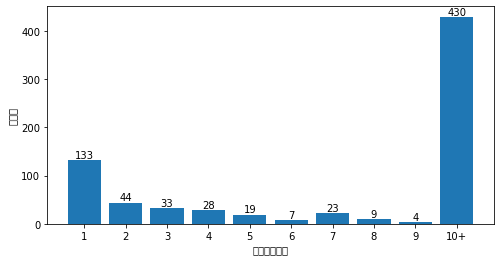

In [6]:
def barr(keys,values):
    fig = plt.figure(figsize=(8,4))
    plt.bar(keys, values)
    for a,b in zip(keys,values):
        plt.text(a, b+0.01, '%.0f' % b, ha='center', va= 'bottom')
    plt.xticks()
    plt.xlabel("项目重用分布", fontproperties="SimSun")
    plt.ylabel("项目数", fontproperties="SimSun")
    plt.show()
num_count = [133,44,33,28,19,7,23,9,4,430]
barr(['1','2','3','4','5','6','7','8','9','10+'],num_count)

In [25]:
#检查
addr = new_df['address']
addr = addr.drop_duplicates()
error = 0
for address in list(addr):
    #print(address)
    if address not in list(bb['code_name']):
        error += 1
print(error)
print(len(addr))

184
566


In [22]:
code_addr = bb['code_name']
code_addr = code_addr.drop_duplicates()
len(code_addr)

419

# function

In [ ]:
del function['line']
del function['dealed_code']

In [ ]:
function

In [ ]:
code_name = []
sol_name = []
code_code = []
sol_code = []
for index,row in match_func.iterrows():
    num = row['code']
    code_name.append(function.loc[num,'code_name'])
    code_code.append(function.loc[num,'code'])
    num = row['snippet']
    sol_name.append(snippet_func.loc[num,'sol_name'])
    sol_code.append(snippet_func.loc[num,'code'])
dd = pd.DataFrame({
    'code_name':code_name,
    'sol_name':sol_name,
    'code':code_code,
    'sol_code':sol_code
})
dd['contract_line'] = get_function_line(dd)

In [ ]:
#dd = dd.rename({'function_line':'contract_line'})
dd

In [ ]:
fengheguai(dd)

In [ ]:
dd

In [ ]:
count_all(dd)

In [ ]:
#dd.to_csv('function_matching.csv')

In [ ]:
#name_func.to_json("function_sol.json")

In [ ]:
del snippet_func['line']
del snippet_func['type']
del snippet_func['ref']
del snippet_func['dealed_code']

In [ ]:
#结果放到frame中
'''
temp3 = slither_result(bb)
bb['slither_result'] = temp3
temp = mythril_check(bb)
bb['mythril_check'] = temp
temp2 = mythril_error_count(bb)
bb['mythril_result']= temp2
temp1 = osiris_result(bb)
bb['osiris_result'] = temp2
#del bb['mythril_check']
sli = slither_get(bb)
bb['slither_analysis'] = sli
osi = osiris_get(bb)
bb['osiris_analysis'] = osi
myt = mythril_get(bb)
bb['mythril_analysis'] = myt
del bb['mythril_check']'''

In [ ]:
'''
def get_similar(bb,thres):
    flag = [False]*len(bb)
    ans = []
    print(len(flag))
    for index,row in bb.iterrows():
        if(flag[index] == False):
            flag[index] = True
            temp = []
            temp.append(index)
            r1_code = row['dealed_code']
            for index2,row2 in bb.iterrows():
                if flag[index2] == False:
                    r2_code = row2['dealed_code']
                    t = sentence_bleu([r1_code],r2_code,smoothing_function=smooth.method1)
                    if(t >= thres):
                        temp.append(index2)
                        flag[index2] = True
            print("---------------------------------"+str(index))
            if(len(temp) > 0):
                ans.append(temp)
                print(temp)
                #for i in temp:
                #    print(bb.loc[i,'dealed_code'])
    return ans
similar = get_similar(bb,0.90)        
similar'''

'''
for index,i in enumerate(similar):
    if len(i) > 1:
        print(i,end = ' ')
        print(index)
        for j in i:
            print(bb.loc[j,'code_index'],end = ' ')
        print()
            #print(bb.loc[j,'sni_index'])
            #print()
for i in similar[5]:
    print(bb.loc[i,'code_index'],end = ' ')
    print(bb.loc[i,'sni_index'])'''
    #print()
    
#将对应的sni处理成list，然后drop——duplicate
#del bb['sni_code']
#del bb['sni_name']
#del bb['sni_index']
#for index,row in bb.iterrows():
#    ind = row['code_index']
#    temp = bb[bb['code_index'] == ind]
    
#tempbb =bb[bb['code_name'] == '0x995AfD0c437f7A9de72816378B2883d5D006659A.sol']
#for i in list(tempbb['sni_code']):
#    print(i)

In [51]:
#append_contract_data
append_contract = pd.read_csv('append_contract_data.csv')
sni_contract = pd.read_csv('snippet_contract_v2.csv')
con_match = pd.read_csv('contract_match_true.csv')
code_contract = pd.read_csv('16w_contract_v2.csv').drop_duplicates(['dealed_code'])

code_function = pd.read_csv('16w_function_v2.csv')
sni_function = pd.read_csv('snippet_function_v2.csv')
fun_match = pd.read_csv('function_match_v2.csv')
seg0 = pd.read_csv("segment_0.9.csv")
seg1 = pd.read_csv("segment_0.8.csv")
temp_idx = list(code_contract.iloc[con_match[con_match['bleu'] >= 0.9]['code']].index) + list(append_contract['code_index'])
temp_idx

[44,
 45,
 46,
 21772,
 7762,
 716,
 2847,
 38100,
 108,
 310,
 51,
 110,
 453,
 40664,
 109,
 46969,
 15,
 66,
 440,
 716,
 875,
 44206,
 44207,
 2889,
 236,
 44208,
 44209,
 33,
 91,
 448,
 24,
 115,
 1603,
 657,
 18,
 33,
 215,
 91,
 935,
 54968,
 1908,
 4,
 13164,
 4667,
 17730,
 0,
 160,
 16,
 36124,
 404,
 4830,
 89,
 527,
 1902,
 116,
 118,
 7273,
 881,
 2215,
 110,
 1531,
 56827,
 42469,
 16379,
 16381,
 2285,
 57036,
 22604,
 4381,
 11876,
 2411,
 65045,
 56430,
 47746,
 102,
 1933,
 540,
 1934,
 23815,
 8957,
 11876,
 53109,
 359,
 1414,
 159,
 160,
 16,
 162,
 163,
 164,
 259,
 1039,
 320,
 258,
 4805,
 884,
 24234,
 2698,
 3812,
 866,
 6929,
 108,
 0,
 82,
 98,
 18,
 26294,
 17730,
 448,
 22629,
 17695,
 24,
 3462,
 56875,
 56876,
 451,
 0,
 13573,
 375,
 23,
 29969,
 2846,
 2847,
 0,
 10224,
 47801,
 3087,
 440,
 224,
 225,
 1042,
 54968,
 114,
 976,
 977,
 197,
 978,
 6969,
 259,
 320,
 322,
 1552,
 3359,
 20883,
 966,
 69,
 100,
 69,
 10148,
 10388,
 1502,
 12786,
 2154,